In [1]:
import torch
import numpy as np
import cv2
import ipdb
import scipy

# from torch import nn
from PIL import Image, ImageOps
import matplotlib.pyplot as plt


from numpy import dot
from numpy.linalg import matrix_rank, inv
from numpy.random import permutation
from scipy.linalg import eigh
from scipy.linalg import norm as mnorm
from scipy.stats import ortho_group

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR

import os


import ica

from modules.util import entropyLoss, getdata, infomaxICA, entropy
# from modules.kde import kernel_density_estimator
# import n_sphere

In [2]:
file_name = os.listdir('./data')
dir_list = []
for name in file_name[0:10]:
    dir_list.append('./data/'+name)
num_of_img = len(dir_list)
# num_of_img = 3
resize = 128

array_list=[]

for img_dir in dir_list:
    image = Image.open(img_dir)
    image = np.array(ImageOps.grayscale(image))
    image = cv2.resize(image, (resize, resize))
#     image = torch.from_numpy(image).float().flatten()
    image = np.expand_dims(image.flatten(), axis=0)
    array_list.append(image)

img_concate = np.concatenate(array_list)
np.random.seed(1)

# D = np.diag(2**np.array([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7], dtype=float))

# B = ortho_group.rvs(dim=num_of_img)
# A = B @ D
# A = np.random.normal(0, 1, size=(num_of_img,num_of_img))
A = np.random.rand(num_of_img,num_of_img)
mixture = A@img_concate

print(A, img_concate.shape, sep='\n')

print('condition number:', np.linalg.cond(A))


[[4.17022005e-01 7.20324493e-01 1.14374817e-04 3.02332573e-01
  1.46755891e-01 9.23385948e-02 1.86260211e-01 3.45560727e-01
  3.96767474e-01 5.38816734e-01]
 [4.19194514e-01 6.85219500e-01 2.04452250e-01 8.78117436e-01
  2.73875932e-02 6.70467510e-01 4.17304802e-01 5.58689828e-01
  1.40386939e-01 1.98101489e-01]
 [8.00744569e-01 9.68261576e-01 3.13424178e-01 6.92322616e-01
  8.76389152e-01 8.94606664e-01 8.50442114e-02 3.90547832e-02
  1.69830420e-01 8.78142503e-01]
 [9.83468338e-02 4.21107625e-01 9.57889530e-01 5.33165285e-01
  6.91877114e-01 3.15515631e-01 6.86500928e-01 8.34625672e-01
  1.82882773e-02 7.50144315e-01]
 [9.88861089e-01 7.48165654e-01 2.80443992e-01 7.89279328e-01
  1.03226007e-01 4.47893526e-01 9.08595503e-01 2.93614148e-01
  2.87775339e-01 1.30028572e-01]
 [1.93669579e-02 6.78835533e-01 2.11628116e-01 2.65546659e-01
  4.91573159e-01 5.33625451e-02 5.74117605e-01 1.46728575e-01
  5.89305537e-01 6.99758360e-01]
 [1.02334429e-01 4.14055988e-01 6.94400158e-01 4.14179270e

# plot of ica.ica1 output

In [3]:
# A0, r, W = ica.ica1(mixture, num_of_img, verbose=True)
# # print(w)


# plt.figure(figsize=(10,10))

# sub_shape = num_of_img

# for i in range(sub_shape):
#     for j in range(sub_shape):
#         plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
#         plt.plot(r[i], r[j], '.', ms=0.1)


# %matplotlib inline

# plt.figure(figsize=(10,10))
# for i in range(num_of_img):
#     plt.subplot(num_of_img, 2, i*2+1)
#     plt.imshow(np.reshape(mixture[i], (resize,resize)), cmap='gray')
#     plt.title('mixture')
#     plt.axis('off')
    
#     plt.subplot(num_of_img, 2, i*2+2)
#     plt.imshow(np.reshape(r[i], (resize,resize)), cmap='gray')
#     plt.title('output')
#     plt.axis('off')

In [4]:
#data whitening
# minim = np.expand_dims(np.min(mixture, axis=1),1)
# maxim = np.expand_dims(np.max(mixture, axis=1),1)
# mixture = (mixture-minim)/(maxim-minim)


# IPT = x_white.copy()
# IPT = torch.from_numpy(IPT).type(torch.float32)
# IPT = torch.from_numpy(mixture).type(torch.float32)
# IPT = (IPT - IPT.mean(axis=1).unsqueeze(1))/(IPT.std(axis=1, unbiased=False).unsqueeze(1))

# IPT_white = IPT.clone()

x_white, white, dewhite = ica.pca_whiten(mixture, num_of_img)

IPT = torch.from_numpy(x_white.copy()).type(torch.float32)

# minim = torch.min(IPT, axis=1)[0].unsqueeze(1)
# maxim = torch.max(IPT, axis=1)[0].unsqueeze(1)
# IPT = (IPT-minim)/(maxim-minim)

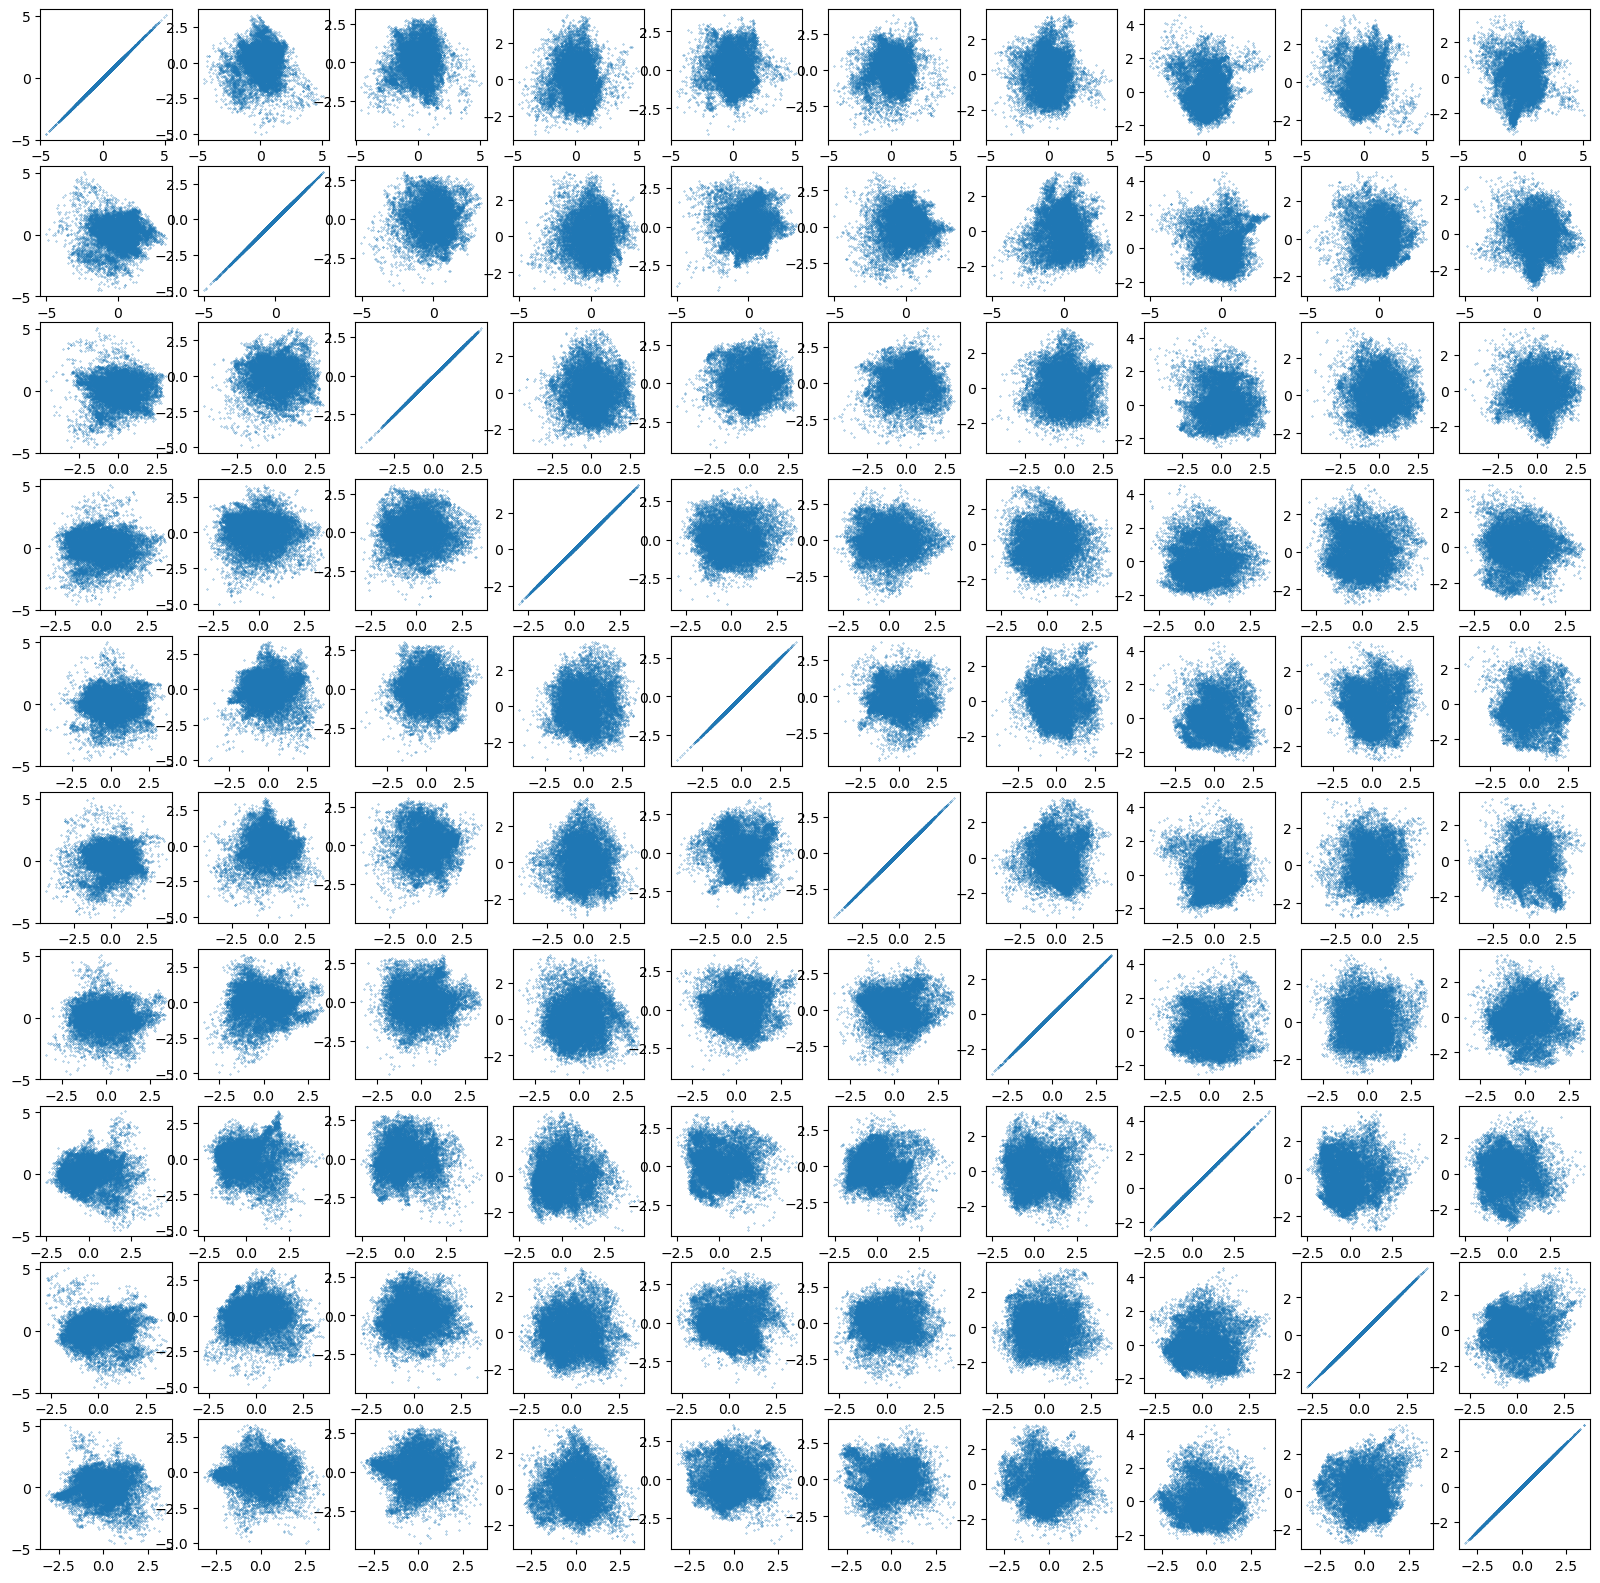

In [5]:
%matplotlib inline
plt.figure(figsize=(20,20))

index = num_of_img

for row in range(index):
    for column in range(index):
        plt.subplot(index, index, row*index + column+1)
        plt.plot(x_white[row], x_white[column], '.', ms=0.5)

In [6]:
# %matplotlib inline
# plt.figure(figsize=(20,20))

# index = num_of_img

# for row in range(index):
#     for column in range(index):
#         plt.subplot(index, index, row*index + column+1)
#         plt.plot(x_white[row], x_white[column], '.', ms=0.5)

In [7]:
device = torch.device('cuda:0')

In [8]:
model = infomaxICA(num_of_img)

In [12]:
for params in model.parameters():
    print(params)

Parameter containing:
tensor([[ 9.5843e-02,  4.2213e-01,  1.4308e-01, -1.0779e-01, -1.3281e-01,
          2.6599e-02, -2.2684e-01, -2.5382e-01,  9.4999e-01,  2.6000e-01],
        [-2.3255e-01,  9.9913e-02, -1.2092e-01, -2.0700e-01, -2.0009e-01,
          1.8202e-01, -3.1655e-01, -3.1943e-01,  8.1718e-01, -2.9084e-01],
        [ 1.0283e-01, -4.3541e-02, -3.1717e-01,  2.7228e-01, -2.8967e-01,
         -1.4448e-01,  6.5023e-01, -2.1875e-01,  9.8890e-02,  1.8537e-01],
        [ 1.6940e-01, -4.7805e-02,  5.1890e-01,  3.5746e-01, -3.2210e-01,
         -2.4912e-02,  4.1172e-01, -3.2315e-01, -3.1705e-01,  2.3369e-01],
        [-3.0126e-01, -3.4066e-02,  4.6049e-01,  4.0556e-01, -1.1569e-01,
          1.0304e-01,  4.5964e-01,  1.7796e-01, -7.8242e-02, -1.2643e-02],
        [ 2.2630e-01, -3.1071e-01,  3.6781e-02, -2.4327e-01,  2.3732e-01,
          5.2381e-01, -3.2629e-04,  7.5345e-02,  4.6260e-01, -1.1310e-01],
        [-1.6963e-01,  3.7339e-02, -1.6497e-01,  4.7672e-01,  2.8194e-01,
         -

In [ ]:
# learning_rate = 0.03 / np.log(num_of_img)
learning_rate = 0.0001
# batch_size = int(np.floor(np.sqrt(IPT.shape[1] / 3)))
# batch_size = int(resize*resize)
batch_size = 16
dataset = getdata(IPT)
# sampler = SequentialSampler(dataset)
sampler = RandomSampler(dataset)
loader = DataLoader(dataset=dataset, sampler=sampler, batch_size=batch_size)

# optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                             lr=learning_rate,
                             eps=10e-4,
                             weight_decay = 1e-4,
                            )


num_epoch = 5000
scheduler = CosineAnnealingLR(optimizer, T_max = num_epoch/2)
# scheduler = OneCycleLR(optimizer, 
#                        learning_rate, 
#                        steps_per_epoch=len(loader), 
#                        epochs=num_epoch,
#                       )

# np.linalg.inv(model.W1.weight.data)

In [ ]:
model = model.to(device)
IPT = IPT.to(device)

In [ ]:
def norm(x):
    """Computes the norm of a vector or the Frobenius norm of a
    matrix_rank
    """
    return torch.norm(torch.flatten(x))

In [ ]:
import math


def cart2spher(cart):
    digits = 6
    result = []
    for element in range(0, len(cart)):
        r = 0
        for i in range(0, len(cart[element])):
            r += cart[element][i]*cart[element][i]
        r = math.sqrt(r)
        convert = [r]
        #-----------------------------------------
        for i in range (0 ,len(cart[element])-2):
            convert.append(round(math.acos(cart[element][i] / r),digits))
            r = math.sqrt(r*r - cart[element][i]*cart[element][i])
        if(cart[element][-1] >= 0):
            convert.append(math.acos(cart[element][-2]/r))
        else:
            convert.append(2*math.pi - math.acos(cart[element][-2] /r))
  
        convert = torch.tensor(convert)
        result += [convert]
    return torch.stack(result)


def spher2cart(otpt):

    multi_sin = torch.sin(otpt).cumprod(1)
    multi_cos = torch.cos(otpt)
    new_multi = multi_cos[:,1:]*multi_sin[:,:-1]

    return torch.cat((multi_cos[:,0:1], new_multi, multi_sin[:,-1:]),dim=1)




def angle2cart(a):
    # a should be in shape [t,d], d for number of dimensions, t for number of pixels
    d = a.shape[1]
    t = a.shape[0]

    r = [1]+[10*2**i for i in range(d-1)] # radii

    multi_sin = torch.sin(a)
    multi_tan = torch.tan(a)

    output = r[0] * multi_sin[:, 0:1] #for x1
    for j in range(1, d): #for x2 to xn
        output = torch.cat((output, (output[:,-1:]/multi_tan[:,j-1:j] + r[j]) * multi_sin[:, j:(j+1)]), 1)
    output = torch.cat((output, output[:, -1:] / multi_tan[:,-1:]), 1)  #for xn+1

    return output

# def angle2cart(a):
#     # a should be in shape [t,d], d for number of dimensions, t for number of pixels
#     d = a.shape[1]
#     t = a.shape[0]

#     r = [3]+[10*2**i for i in range(d-1)] # radii

#     multi_sin = torch.sin(a)
#     multi_tan = torch.tan(a)
#     multi_cos = torch.cos(a)

#     output = r[0] * multi_sin[:, 0:1] #for x1
    
#     output = torch.cat((output, (output[:,-1:]/multi_tan[:,0:1] + r[1]) * multi_sin[:, 1:2]), 1)
    
#     output = torch.cat((output, (output[:,-2:-1]/multi_tan[:,0:1] + r[1]) * multi_cos[:, 1:2]), 1)  #for xn+1

#     return output

In [ ]:
# def batch_loss(x, k=3):
#     d = x.shape[1]
#     perm = torch.randperm(d)
#     loss = torch.tensor([0]).type(torch.float32).cuda()
#     for i in range(d):
#         loss += entropy(opt[:,i:i+1], k=k)
# #     for i in range(d-2):
# #         for j in range(i+1,d-1):
# #             for m in range(j+1,d):
# #                 loss += entropy(opt[:, (i,j,m)], k=k)
            
#     return loss

In [ ]:
loss_tracker_w1 = []
loss_tracker_w2 = []

In [ ]:
%matplotlib notebook

k = int(batch_size*0.16)

fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
# ax2 = fig.add_subplot(133, projection='3d')
ax3 = fig.add_subplot(133)

# trace = []
change = 100
W_STOP = 1e-6
d_weigths = torch.zeros(num_of_img)
old_d_weights = torch.zeros([1, num_of_img])
torch_pi = torch.acos(torch.zeros(1)).item() * 2 

# for epoch in range(num_epoch):
step0 = 0
angle_delta = 0
while step0 < num_epoch and change > W_STOP:
# for i in range(1000):
    LOSS_w1 = 0
    LOSS_w2 = 0
    old_weight = torch.clone(model.W1.weight.data)
    for step, ipt in enumerate(loader):
        model.zero_grad()
        ipt = ipt.to(device)
        
        opt_w1, opt_w2 = model.forward(ipt)
#------------------------------sphe2cartesin----------------------------------
        
#         opt = angle2cart(opt)
#         opt = spher2cart(opt)
    
#---------------------------------------------------------------
#         loss = entropyLoss(opt.permute(1,0), device=device)
        loss_w1 = entropy(opt_w1, k=k, dis=1)
        loss_w2 = entropy(opt_w2, k=k, dis=1)
        loss_w1.backward(retain_graph=True)
        loss_w2.backward()
        optimizer.step()
        LOSS_w1+=loss_w1
        LOSS_w2+=loss_w2
    d_weigths = model.W1.weight.data - old_weight
    change = norm(d_weigths)**2
    d_weigths = d_weigths.cpu()
    if step > 2:
        angle_delta = torch.arccos(
                    torch.sum(d_weigths * old_d_weights) /
                    (norm(d_weigths) * norm(old_d_weights) + 1e-8)
                ) * 180 / torch_pi
    if angle_delta > 60:
        learning_rate = learning_rate * 0.9
        
        print('lr changed to:', learning_rate)
        
        optimizer.param_groups[0]['lr'] = learning_rate
        old_d_weights = torch.clone(d_weigths)
    elif step == 1:
        old_d_weights = torch.clone(d_weigths)
        
        
        
    LOSS_w1 = LOSS_w1.cpu()
    LOSS_w2 = LOSS_w2.cpu()
    loss_tracker_w1.append(LOSS_w1.detach().numpy()/len(loader.sampler))
    loss_tracker_w2.append(LOSS_w2.detach().numpy()/len(loader.sampler))
    if step0 % 2 == 0:
        
#         index = np.random.randint(0,num_of_img, 2)
        index = [0,1]
        ax.clear()
        ax.plot(loss_tracker_w1[-100:])
        fig.canvas.draw()
    
        data = (IPT.T@model.W1.weight.data.T).cpu().detach().numpy()
        _, data1 = model.forward(IPT.T)
#         data2 = angle2cart(data1).cpu().detach().numpy()
#         data2 = spher2cart(data1).cpu().detach().numpy()
        data1 = data1.cpu().detach().numpy()
        
#         data2 = data.cpu().detach().numpy()
        ax1.clear()
        ax1.plot(data[:, index[0]], data[:, index[1]], '.', ms=0.5)
        fig.canvas.draw()
        
#         ax2.clear()
#         ax2.scatter(data2[:,-1], data2[:,-2], data2[:,-3], c = 'r', s=0.1)

# #         ax2.set_xlim3d(-2,2)
# #         ax2.set_ylim3d(-2,2)
# #         ax2.set_zlim3d(-2,2)
#         ax2.set_xlim3d(-10,10)
#         ax2.set_ylim3d(-10,10)
#         ax2.set_zlim3d(-10,10)
        
#         fig.canvas.draw()

        ax3.clear()
        
        ax3.plot(data1[:, index[0]], data1[:, index[1]], '.', ms=0.5)
        fig.canvas.draw()
        

    

    step0 += 1
    print(step0, angle_delta, LOSS_w2.detach().numpy()/len(loader.sampler), change)
    scheduler.step()

In [ ]:
%matplotlib inline
plt.plot(loss_tracker_w2)

In [ ]:
# %matplotlib notebook
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# # Data for a three-dimensional line
# zline = data2[:, -1]
# xline = data2[:, -2]
# yline = data2[:, -3]

# ax.set_xlim3d(-10,10)
# ax.set_ylim3d(-10,10)
# ax.set_zlim3d(-10,10)

# ax.scatter(xline, yline, zline, c = 'r', s=0.1)

In [ ]:
# %matplotlib inline

# plt.plot(data2[:,0], data2[:,1], '.', ms=0.5)
# plt.axis('square')

In [ ]:
# nn_rescale_opt = data.copy()

# nn_rescale_opt[nn_rescale_opt>np.pi] -= np.pi
# nn_rescale_opt[nn_rescale_opt<-np.pi] += np.pi

# nn_rescale_opt[nn_rescale_opt>np.pi] -= 2*np.pi
# nn_rescale_opt[nn_rescale_opt<-np.pi] += 2*np.pi

# %matplotlib inline
# plt.plot(nn_rescale_opt[:,0], nn_rescale_opt[:,1], '.', ms=0.5)
# plt.axis('square')

In [ ]:
# %matplotlib notebook
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# # Data for a three-dimensional line
# zline = data2[:, -1]
# xline = data2[:, -2]
# yline = data2[:, -3]
# ax.scatter(xline, yline, zline, c = 'r', s=0.1)

# ax.set_xlim3d(-10,10)
# ax.set_ylim3d(-10,10)
# ax.set_zlim3d(-10,10)

# plt.axis('auto')

In [ ]:
# # generate uniform dense torus for compare

# rand_val = torch.randn(4096, num_of_img) 
# A = torch.tanh(rand_val)*np.pi*2
# P = angle2cart(A)

# %matplotlib notebook
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# # Data for a three-dimensional line
# zline = P[:, -1]
# xline = P[:, -2]
# yline = P[:, -3]
# ax.scatter(xline, yline, zline, c = 'r', s=0.1)

# ax.set_xlim3d(-10,10)
# ax.set_ylim3d(-10,10)
# ax.set_zlim3d(-10,10)

In [ ]:
# opt = model.forward(IPT.T).cpu()
# opt = angle2cart(opt)

# print('the eutropy of uniform:', entropy(P, k=3))
# print('the entropy of angle to cart:', entropy(opt, k=3))

In [ ]:
# model = model.cpu()
# IPT = IPT.cpu()
# data = (IPT.T@model.W1.weight.data.T).cpu().detach().numpy()

In [ ]:
# data = (IPT.T@model.W1.weight.data.T).cpu().detach().numpy()
# data = model.forward(IPT.T).cpu().detach().numpy()


In [ ]:
# %matplotlib inline
# # plt.plot(data[:,0], data[:,1], '.', ms=0.5)
# # # plt.axis('square')
# plt.figure(figsize=(10,10))
# sub_shape = num_of_img
# for i in range(sub_shape):
#     for j in range(sub_shape):
#         plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
#         plt.plot(data[:, i], data[:, j], '.', ms=1)
#         plt.axis('square')

In [ ]:
# %matplotlib inline

# plt.figure(figsize=(10,5*num_of_img))
# for i in range(num_of_img):
#     plt.subplot(num_of_img, 3, i*3+1)
#     plt.imshow(np.reshape(array_list[i], (resize,resize)), cmap='gray')
#     plt.title('original')
#     plt.axis('off')
    
#     plt.subplot(num_of_img, 3, i*3+2)
#     plt.imshow(np.reshape(x_white[i], (resize,resize)), cmap='gray')
#     plt.title('mixture')
#     plt.axis('off')
    
#     plt.subplot(num_of_img, 3, i*3+3)
#     plt.imshow(np.reshape(data[:, i], (resize,resize)), cmap='gray')
#     plt.title('output')
#     plt.axis('off')

In [ ]:
# for i in range(sub_shape):
#     for j in range(sub_shape):
#         plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
#         plt.plot(data2.T[:, i], data2.T[:, j], '.', ms=1)
#         plt.axis('square')

In [ ]:
# def myISI(WAr):
#     N = WAr.shape[0]
#     WAr = np.abs(WAr)
#     ISI = 0.
#     ISI += np.sum(np.sum(WAr,axis=1)/np.max(WAr,axis=1) - 1)
#     # np.max(WAr,axis=1)
#     ISI += np.sum(np.sum(WAr,axis=0)/np.max(WAr,axis=0) - 1)
#     # np.max(WAr,axis=0)
#     ISI = ISI/(2*N*(N-1))
#     return ISI

# w_mnn = model.W1.weight.data.detach().numpy()
# print('myISI(w_mnn*A)=', myISI(w_mnn*A))
# print('myISI(white*A)=', myISI(white*A))
# print('myISI(w_mnn*white)=', myISI(w_mnn*white))
# print('myISI(w_mnn*white.T)=', myISI(w_mnn*white.T))

In [ ]:
mixer, b, unmixer = ica.ica1(mixture, ncomp=num_of_img, verbose=True)

In [ ]:
# %matplotlib inline

# plt.figure(figsize=(10,5*num_of_img))
# for i in range(num_of_img):
#     plt.subplot(num_of_img, 3, i*3+1)
#     plt.imshow(np.reshape(array_list[i], (resize,resize)), cmap='gray')
#     plt.title('original')
#     plt.axis('off')
    
#     plt.subplot(num_of_img, 3, i*3+2)
#     plt.imshow(np.reshape(x_white[i], (resize,resize)), cmap='gray')
#     plt.title('mixture')
#     plt.axis('off')
    
#     plt.subplot(num_of_img, 3, i*3+3)
#     plt.imshow(np.reshape(-b[i], (resize,resize)), cmap='gray')
#     plt.title('output')
#     plt.axis('off')

In [ ]:
# model = model.cpu()
# IPT = IPT.cpu()
# data = (IPT.T@model.W1.weight.data.T).cpu().detach().numpy()
data = model.forward(IPT.T)[1].cpu().detach().numpy()

In [ ]:
%matplotlib inline
# plt.plot(data[:,0], data[:,1], '.', ms=0.5)
# # plt.axis('square')
plt.figure(figsize=(10,10))
sub_shape = num_of_img
for i in range(sub_shape):
    for j in range(sub_shape):
        plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
        plt.plot(data[:, i], data[:, j], '.', ms=1)
        plt.axis('square')

In [ ]:
%matplotlib inline
# plt.plot(data[:,0], data[:,1], '.', ms=0.5)
# # plt.axis('square')
plt.figure(figsize=(10,10))
sub_shape = num_of_img
for i in range(sub_shape):
    for j in range(sub_shape):
        plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
        plt.plot(b[i], b[j], '.', ms=1)
        plt.axis('square')

In [ ]:
b.shape

In [ ]:
data.shape

In [ ]:
map_k_i = np.corrcoef(data.T, b)
map_k_white = np.corrcoef(data.T, x_white)
map_i_white = np.corrcoef(b, x_white)

In [ ]:
plt.imshow(map_k_i, cmap='gist_heat')

In [ ]:
plt.imshow(map_k_white, cmap='gist_heat')

In [ ]:
plt.imshow(map_i_white, cmap='gist_heat')

In [ ]:
data = IPT.T@model.W1.weight.data.T
# data = model.forward(IPT.T)

scale = data.std(axis=0).reshape((1, -1))
data = data / scale

In [ ]:
data.shape

In [ ]:
print(600)

In [ ]:
entropy(data, k=k)

In [ ]:
entropy(b.T, k=k)

In [ ]:
data.var()

In [ ]:
b.var()

In [ ]:
%matplotlib inline

plt.figure(figsize=(10,5*num_of_img))
for i in range(num_of_img):
    plt.subplot(num_of_img, 3, i*3+1)
    plt.imshow(np.reshape(array_list[i], (resize,resize)), cmap='gray')
    plt.title('original')
    plt.axis('off')
    
    plt.subplot(num_of_img, 3, i*3+2)
    plt.imshow(np.reshape(x_white[i], (resize,resize)), cmap='gray')
    plt.title('mixture')
    plt.axis('off')
    
    plt.subplot(num_of_img, 3, i*3+3)
    plt.imshow(np.reshape(data[:, i], (resize,resize)), cmap='gray')
    plt.title('output')
    plt.axis('off')